# Mesh2d refine ridges based on gridded samples

At the very beginning, the necessary libraries have to be imported.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from meshkernel import (
    GeometryList,
    GriddedSamples,
    MakeGridParameters,
    MeshKernel,
    MeshRefinementParameters,
    RefinementType,
    GriddedSamples,
)

`meshkernel` provides a set of convenience methods for creating common meshes.

We use the `curvilinear_compute_rectangular_grid` method to create a simple curvilinear grid.
You can look at the documentation in order to find all its parameters.

In [2]:
mk = MeshKernel()

num_rows = 21
num_columns = 41

make_grid_parameters = MakeGridParameters()
make_grid_parameters.num_columns = num_columns
make_grid_parameters.num_rows = num_rows
make_grid_parameters.angle = 0.0
make_grid_parameters.origin_x = 0.0
make_grid_parameters.origin_y = 0.0
make_grid_parameters.block_size_x = 10.0
make_grid_parameters.block_size_y = 10.0

mk.curvilinear_compute_rectangular_grid(make_grid_parameters)

We convert the curvilinear grid to an unstructured mesh and get the resulting mesh2d

In [3]:
mk.curvilinear_convert_to_mesh2d()
mesh2d_input = mk.mesh2d_get()

The generated mesh can be visualized as follow

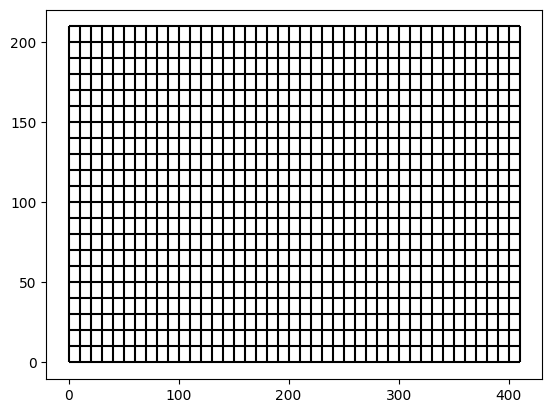

In [4]:
fig, ax = plt.subplots()
mesh2d_input.plot_edges(ax, color="black")

Now we define the gridded samples with uniform spacing

In [5]:
def read_asc_file(file_path, dtype=np.float32):
    """Reads asc file and returns headers and data as numpy array
    Args:
            file_path (str): The file path
    Returns:
            header: The ascii header
            data: The ascii data as a numpy array of doubles
    """

    header = {}
    data = []

    with open(file_path, "r") as file:
        # Read header information
        for _ in range(6):
            line = file.readline().strip().split()
            header[line[0]] = float(line[1])

        # Read data values
        for line in file:
            data_row = [float(value) for value in line.strip().split()]
            data.insert(0, data_row)  # Insert row at the beginning

        # Flatten the data
        data = np.array(data).flatten().astype(dtype)

    return header, data

In [6]:
header, values_np = read_asc_file("./data_examples/gaussian_bump.asc", dtype=np.float32)

We can visualize the data read from asc

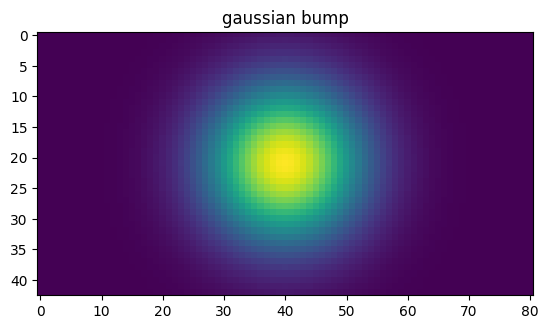

In [7]:
values_np_matrix = np.reshape(values_np, (int(header["nrows"]), int(header["ncols"])))
plt.imshow(values_np_matrix, cmap="viridis", interpolation="nearest")
plt.title("gaussian bump")
plt.show()

We can store the ascii data in a gridded sample instance, assuming uniform spacing

In [8]:
num_sample_x_coordinates = (num_columns - 1) * 2 + 1
num_sample_y_coordinates = (num_rows - 1) * 2 + 1
gridded_samples = GriddedSamples(
    num_x=num_sample_x_coordinates,
    num_y=num_sample_y_coordinates,
    x_origin=0.0,
    y_origin=-0.0,
    cell_size=5.0,
    values=values_np,
)

Set the parameters for the mesh refinement algorithm. Note the ridge refinement type must be set correctly 

In [9]:
refinement_params = MeshRefinementParameters(
    refine_intersected=False,
    use_mass_center_when_refining=False,
    min_edge_size=2.0,
    refinement_type=RefinementType.RIDGE_DETECTION,
    connect_hanging_nodes=True,
    account_for_samples_outside_face=False,
    max_refinement_iterations=1,
)

Refinement can now be performed

In [10]:
relative_search_radius = 1.01
minimum_num_samples = 1
number_of_smoothing_iterations = 0

mk.mesh2d_refine_ridges_based_on_gridded_samples(
    gridded_samples=gridded_samples,
    relative_search_radius=relative_search_radius,
    minimum_num_samples=minimum_num_samples,
    number_of_smoothing_iterations=number_of_smoothing_iterations,
    mesh_refinement_params=refinement_params,
)

We can now visualize the refined grid

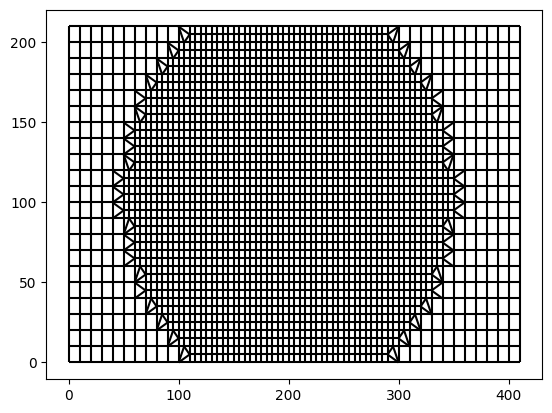

In [11]:
mesh2d_output = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d_output.plot_edges(ax, color="black")